In [1]:
import os
import socket
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, List

import torch
import torch.nn as nn
import torch.optim as optim

from diffusion import create_diffusion
from diffusers.models import AutoencoderKL
from models import DiT_S_2

from torch import Tensor
from torch.utils.data import Dataset, Subset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms as T

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Host: {socket.gethostname()}")
print(f"Device: {device.upper()}")

Host: diamant.cip.ifi.lmu.de
Device: CPU


### ImageNet Data

Data-Path: ./data
Dataset: 50000 Images
Image Shape: (3, 256, 256)


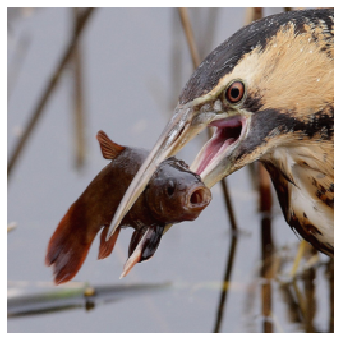

In [2]:
PATH = "./data"
IMG_DIM = (3, 256, 256)
LATENT_DIM = 32
N_CLASS = 1000
TRANSFORM = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])

dataset = ImageFolder(PATH, transform=TRANSFORM)
dataloader = DataLoader(dataset, batch_size=1)
img, trgt = dataset[10]

print(f"Data-Path: {PATH}")
print(f"Dataset: {len(dataset)} Images")
print(f"Image Shape: {tuple(img.shape)}")

plt.figure(figsize=(6, 6))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.show()

In [4]:
model = DiT_S_2(input_size=LATENT_DIM, num_classes=N_CLASS)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0)
diffusion = create_diffusion(timestep_respacing="")
loss_dict = 0

for _, y in dataloader:
    model.train()
    
    x = torch.rand(1, 4, 32, 32, requires_grad=True)
    t = torch.randint(0, 1000, (x.shape[0],))
    model_kwargs = dict(y=y)
    print(f"x: {tuple(x.shape)}")
    print(f"y: {y}")
    print(f"t: {t}\n")

    loss_dict = diffusion.training_losses(model, x, t, model_kwargs)
    loss = loss_dict["loss"].mean()
    loss.backward()
    optimizer.step()
    
    print(loss_dict["loss"])
    print(loss)
    print(x.grad.shape)
    model.eval()
    break


x: (1, 4, 32, 32)
y: tensor([0])
t: tensor([285])



/home/c/cimsir/.local/lib/python3.8/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/c/cimsir/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


tensor([1.0065], grad_fn=<AddBackward0>)
tensor(1.0065, grad_fn=<MeanBackward0>)
torch.Size([1, 4, 32, 32])
